# Boston and Seattle AirBnB Datasets - Data Cleaning

   * Author: Jared Thacker


## Business Understanding
**I would like to analyze this dataset under the following scenario**:

The business scenario/setting is that of an individual who would like to buy a property in Boston or Seattle to list on airbnb in order to generate an extra stream of cash for themselves. Not knowing anything about this industry/space this individual decides to download data from both cities and wants to understand the relationships between some of the variables/features provided.

How does the price of a rental price change if a property has 1 bedroom? 2-3 bedrooms? What about bathrooms? How does the city affect the price of rental for the property? Number of amenities provided for the guest? What would be a ball-park estimate of rental price given information about a property? Can we get any insight into what guests care about based on the complaints in bad reviews? What about high reviews? How does price/vacancy rates of properties depend on location within each city?

These are examples of questions that this analysis will attempt to cover. The methods used to answer these questions are visualizations, confidence intervals/hypothesis testing and linear regression. Highly accurate machine learning (ML) models are not required for understanding relationships/inference and will thus not be used. In addition, neither will model selection/feature selection - the entrepreneur/analyst has a general picture of the variables that they would like to explore and understand.

This notebook focuses on _**data cleaning**_ (hence the name).

**Note**: Anytime I perform feature engineering I will make a note in large bold that says: **Feature Engineering Task**

## Data Understanding
The airbnb datasets consists of 6 total datasets contained in .CSV format. The 6 datasets described rental property information in two different cities, namely, Boston and Seattle. There are 3 different types of datasets that make up all of the data (the 6 datasets just mentioned):

   * Calendar datasets - contains temporal data on the daily rental price of all listed rental properties in a particular city.
   * Listings datasets - contains qualitative (e.g Aparment/House) and quantitative (e.g number of bedrooms) information about all property listings in a particular city.
   * Reviews datasets - contains the reviews comments, property listings, reviewer name etc that were left for all listed rental properties in a particular city.

## Table of Contents

1. [Imports](#imports)<br>
2. [Gathering](#gathering)<br>
3. [Duplicate Samples Analysis](#duplicates)<br>
4. [Missingness Analysis](#missingness)<br>
5. [Drop Unimportant Features #1](#firstround)<br>
6. [Drop Unimportant Features #2](#secondround)<br>
7. [Data Cleaning (On Boston Data)](#cleaning)<br>
   a. [Issue #1](#i1)<br>
   b. [Issue #2](#i2)<br>
   c. [Issue #3](#i3)<br>
   d. [Issue #4](#i4)<br>
   e. [Issue #5](#i5)<br>
   f. [Issue #6](#i6)<br>
   g. [Issue #7](#i7)<br>
   h. [Issue #8](#i8)<br>
   i. [Issue #9](#i9)<br>
   j. [Issue #10](#i10)<br>
   k. [Issue #11](#i11)<br>
   l. [Issue #12](#i12)<br>
8. [Clean Seattle](#cleanseattle)<br>
9. [Comparing the Structure of Boston vs. Seattle](#comp)<br>
10. [JSONs of Feature Types For the Listings Datasets](#jsontypes)<br>
11. [Make Aggregated Calendar Dataset and Merge with Calendar Dataset](#mergecalendar)<br>
   a. [For the Boston Dataset](#mergebostoncalendarlistings)<br>
   b. [For the Seattle Dataset](#mergeseattlecalendarlistings)<br>
12. [Make JSON of Data Types For Merged Calendar Datasets](#aggmergecal)<br>
13. [Make JSON of Data Types For Concatenated Calendar Datasets](#jsonconcaggs)<br>
14. [Merge Seattle Listings and Calendar Datasets](#mergeseattlecalendarlistings)<br>
15. [Make JSON of Data Types For the Merged Calendar and Listings Datasets](#typejsonmergedcalendarlistings)<br>
16. [Add City as a Feature to the Reviews Datasets, merge, then save](#addcityreviews)<br>

<img src="img/logo.png" alt="alt_text" align="left" width="600" height="600" />

<a id='imports'></a>

In [1]:
# Imports

# Import modules made by me
import pretty_plots.plots as pts
import cleaning_utils.clean as c

# Other Imports (by smart open-sourcers)
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import seaborn as sns
import matplotlib.ticker as tick
import missingno as msno
import fancyimpute
import statsmodels.stats.api as sms

### Gathering: Import all Data
Each dataset is .csv, so this can be done easily enough using Pandas.read_csv()

There are 3 datasets to import:
   * Calendar, including listing id and the price and availability for that day
   * Listings, including full descriptions and average review score
   * Reviews, including unique id for each reviewer and detailed comments

<a id='gathering'></a>

In [2]:
# all boston data
boston_calendar = pd.read_csv('./boston_data/calendar.csv', parse_dates=['date'])
boston_listings = pd.read_csv('./boston_data/listings.csv', parse_dates=['host_since'])
boston_reviews = pd.read_csv('./boston_data/reviews.csv', parse_dates=['date'])

# all seattle data
seattle_calendar = pd.read_csv('./seattle_data/calendar.csv', parse_dates=['date'])
seattle_listings = pd.read_csv('./seattle_data/listings.csv', parse_dates=['host_since'])
seattle_reviews = pd.read_csv('./seattle_data/reviews.csv', parse_dates=['date'])

In [3]:
print(f'Boston Calendar Shape: ({boston_calendar.shape[0]:,} rows, {boston_calendar.shape[1]} columns)')
print(f'Boston Listings Shape: ({boston_listings.shape[0]:,} rows, {boston_listings.shape[1]} columns)')
print(f'Boston Reviews Shape: ({boston_reviews.shape[0]:,} rows, {boston_reviews.shape[1]} columns)')
print(f'Seattle Calendar Shape: ({seattle_calendar.shape[0]:,} row, {seattle_calendar.shape[1]} columns)')
print(f'Seattle Listings Shape: ({seattle_listings.shape[0]:,} rows, {seattle_listings.shape[1]} columns)')
print(f'Seattle Reviews Shape: ({seattle_reviews.shape[0]:,} rows, {seattle_reviews.shape[1]} columns)')

Boston Calendar Shape: (1,308,890 rows, 4 columns)
Boston Listings Shape: (3,585 rows, 95 columns)
Boston Reviews Shape: (68,275 rows, 6 columns)
Seattle Calendar Shape: (1,393,570 row, 4 columns)
Seattle Listings Shape: (3,818 rows, 92 columns)
Seattle Reviews Shape: (84,849 rows, 6 columns)


<a id='duplicates'></a>

## Assess: Duplicate Samples Analysis
The only dataset that has any duplicate values is the Boston calendar dataset which contains the prices of using the property on a particular date.


Note, I check for duplicates in each of the datasets as follows:
   * **boston_calendar** or **seattle_calendar** - Just check if the entire row is the same as another row
   * **boston_listings** or **seattle_listings** - there is only supposed to be _one_ row per property, so check for duplicates by looking for duplicate ***id***s
   * **boston_reviews** or **seattle_review** - there should only be one reviewer (***id***) per ***date*** per listing ***listing_id***. So use these variables to check for duplicates
   

#### Conclusion:
There were only duplicate values present in the ***boston_calendar*** dataset. If we select only those duplicate values from the original ***boston_calendar*** dataset, then we can see that the presence of duplicates is because of two reasons:
   * There are a lot of NaNs in the **price** features - this cannot be fixed as this is my response for my linear regression (see data analysis notebook).
   * There is *one* property that remained vacant for nearly 3 months (89 days to be exact, see code cells below) and the price remained fixed for that period of time - this is a real occurrence in the data and should not be removed.
   

In [4]:
# Define dictionaries to access the different datasets
dataset_dict = {'boston_calendar':boston_calendar, 'boston_listings':boston_listings,
                'boston_reviews':boston_reviews, 'seattle_calendar':seattle_calendar,
                'seattle_listings':seattle_listings, 'seattle_reviews':seattle_reviews}

# duplicate_dict will contain the name and dataframe of those who have any duplicate values, so I can
# access those later
duplicate_dict = {}

# by_dict contains the subset variables that I will used to define a duplicate row
by_dict = {'calendar':None, 'listings':['id'], 'reviews':['listing_id', 'id', 'date']}

# now loop through the names and datasets and check for duplicate values
for name, dataset in dataset_dict.items():
    dataset_type = name.split('_')[1]
    subvars = by_dict[dataset_type]
    temp = dataset.duplicated(subset=subvars)
    temp_sum = temp.sum()
    if temp_sum > 0:
        duplicate_dict[name] = dataset
        print(f"{name.replace('_', ' ').title()} has {temp_sum:,} duplicate values.")

Boston Calendar has 365 duplicate values.


In [5]:
# Isolate duplicate rows from boston_calendar dataset
# 285 there are 285 missing values in price - should be dropped, since the mean of
# price will be my response
bost_cal_duplicates = boston_calendar[boston_calendar.duplicated()]
bost_cal_duplicates.isna().sum()

listing_id      0
date            0
available       0
price         285
dtype: int64

In [6]:
# Isolate duplicate values where price is not null
bost_cal_dupl_not_null = bost_cal_duplicates[bost_cal_duplicates.notnull()['price']]

In [7]:
# This dataframe is for the property that was vacant for nearly 3 months
bost_cal_dupl_not_null

,listing_id,date,available,price
748761,12898806,2016-12-04,t,$220.00
748762,12898806,2016-12-03,t,$220.00
748763,12898806,2016-12-02,t,$220.00
748764,12898806,2016-12-01,t,$220.00
748765,12898806,2016-11-30,t,$220.00
...,...,...,...,...
748869,12898806,2016-09-10,t,$220.00
748870,12898806,2016-09-09,t,$220.00
748871,12898806,2016-09-08,t,$220.00
748872,12898806,2016-09-07,t,$220.00


In [8]:
# Verify there is only ONE property in this dataframe
bost_cal_dupl_not_null['listing_id'].value_counts(normalize=True)

12898806    1.0
Name: listing_id, dtype: float64

In [9]:
# Verify that it was ALWAYS available during this 3 month timeframe
bost_cal_dupl_not_null['available'].value_counts(normalize=True)

t    1.0
Name: available, dtype: float64

In [10]:
# Sort this data frame by date to verify lenght of time it was vacant
bost_cal_dupl_not_null = bost_cal_dupl_not_null.sort_values(by='date').copy(deep=True)

In [11]:
# Calculate time this property was vacant
end_date = bost_cal_dupl_not_null['date'].iloc[-1]
start_date = bost_cal_dupl_not_null['date'].iloc[0]
total_time = (end_date - start_date).days
print(f'The total elapsed time that this property remained vacant is {total_time:,} days')

The total elapsed time that this property remained vacant is 89 days


<a id='missingness'></a>

# Assess: Missingness Analysis
The (rental) price of the listing is what I'm wanting to predict (the target), so any NAs will need to be dropped. None of the other features (listing_id, date, available) have any missing values.

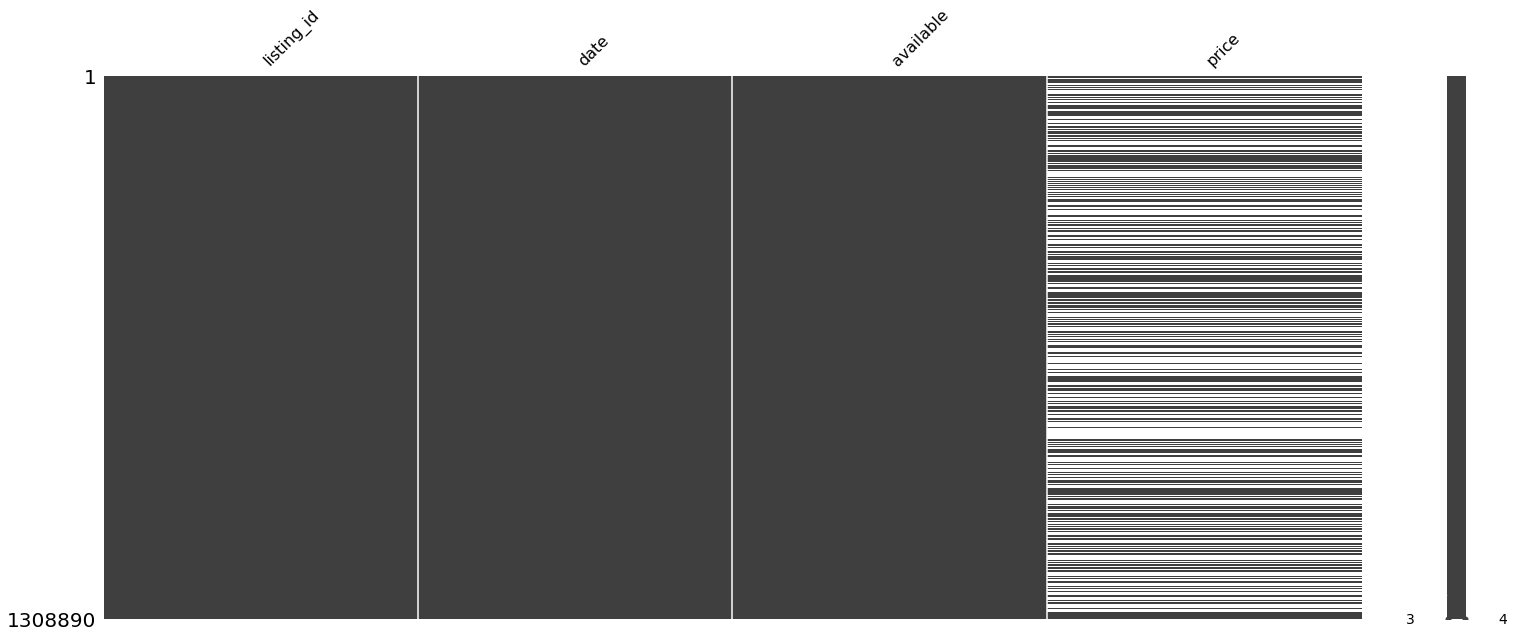

In [12]:
# Display missingness matrix for the calendar dataset
msno.matrix(boston_calendar)
plt.show()

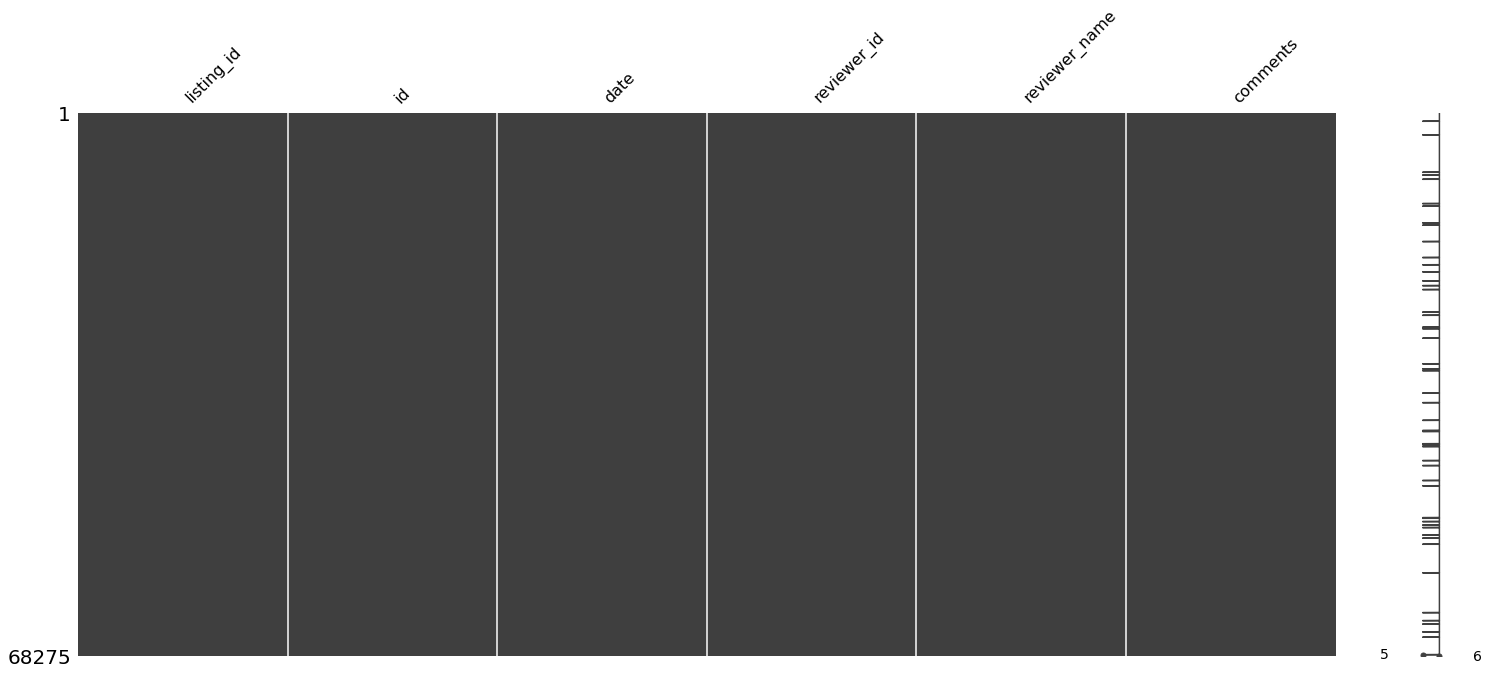

In [13]:
# Display missingness matrix for the reviews dataset
msno.matrix(boston_reviews)
plt.show()

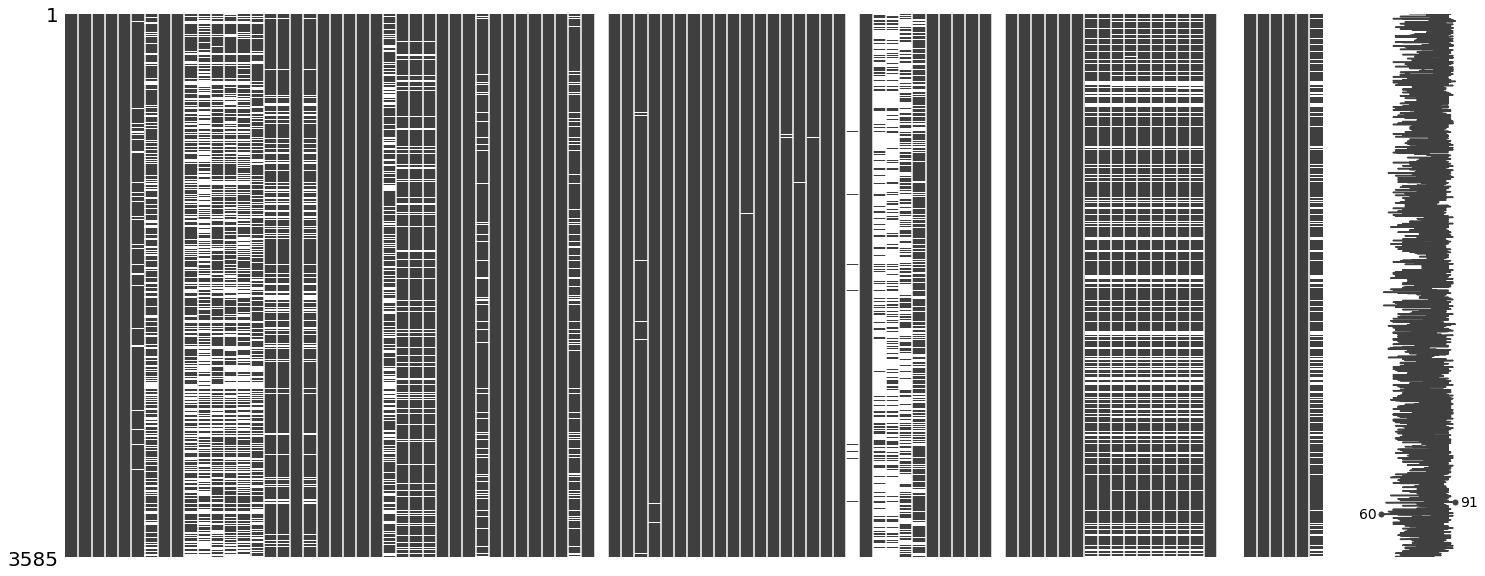

In [14]:
# Display missingness matrix for the listings dataset
msno.matrix(boston_listings)
plt.show()

<a id='firstround'></a>

## Clean: Features dropped: justification
   1. These features are unique to each listing and won't be useful for analysis (at least not for purposes in this analysis):
      * **listing_url**
      * **scrape_id**
      * **thumbnail_url**
      * **medium_url**
      * **picture_url**
      * **xl_picture_url**
   2. These features have zero variance:
      * **state**
      * **country**
      * **country_code**
   3. These features I just don't see being useful or interesting:
      * **host_id**
      * **host_name**
      * **host_thumbnail_url**
      * **host_picture_url**
      * **last_scraped**
      * **calendar_last_scraped**
   4. These features are in the boston dataset, but not the seattle dataset
      * **access**
      * **interaction**
      * **house_rules**

In [15]:
# Make of a list of the (bigger) Boston listings features that are
# not in the (smaller) seattle listings dataset
missing_features = []
for feature in boston_listings.columns:
    if feature not in seattle_listings.columns:
        missing_features.append(feature)

### Feature Engineering Task:
**number_of_NAs**: the number of missing values that a row has

In [16]:
# Make a feature that is the number of missing values in a row
boston_listings['number_of_NAs'] = boston_listings.isnull().sum(axis=1)

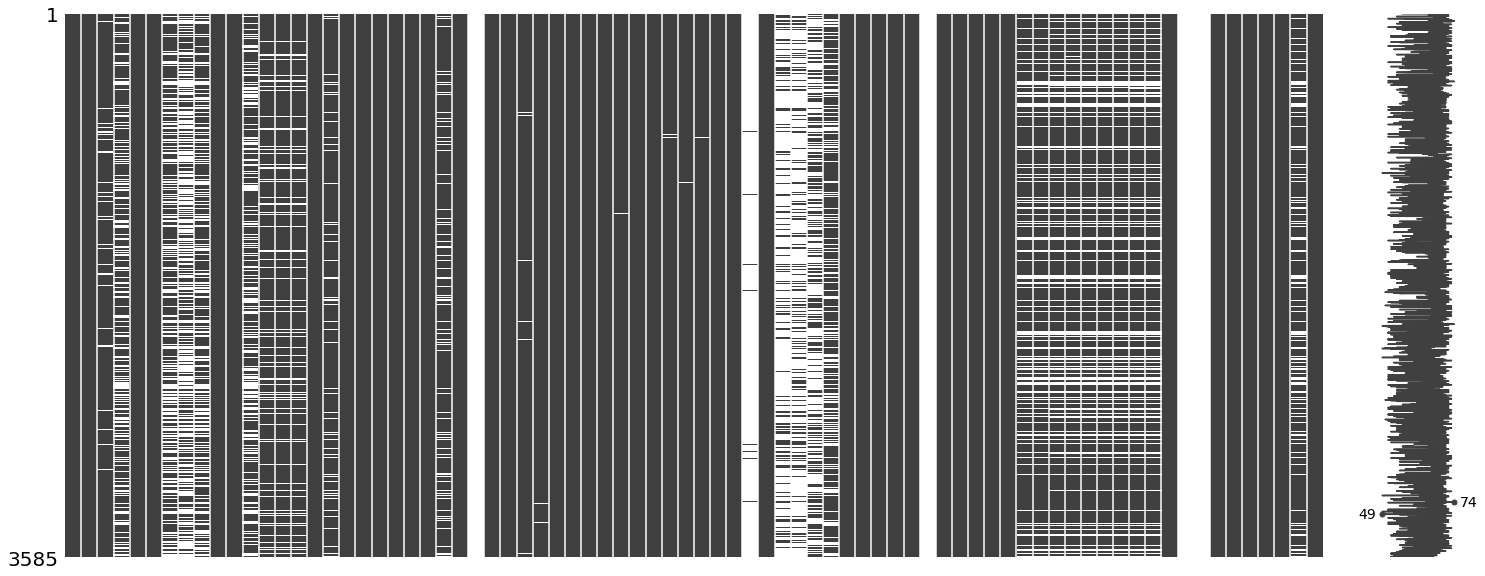

In [17]:
# Get rid of features that are either textual (that I don't plan to use) or I don't see
# being useful (like the airbnb URL for the property)
features_to_drop = ['listing_url', 'scrape_id', 'last_scraped', 'thumbnail_url', 'medium_url',
                    'picture_url', 'xl_picture_url', 'host_id', 'host_url', 'host_name', 'host_thumbnail_url',
                    'host_picture_url', 'country', 'country_code', 'calendar_last_scraped', 'access','interaction',
                    'house_rules']
boston_listings.drop(columns=features_to_drop, inplace=True)
msno.matrix(boston_listings)
plt.show()

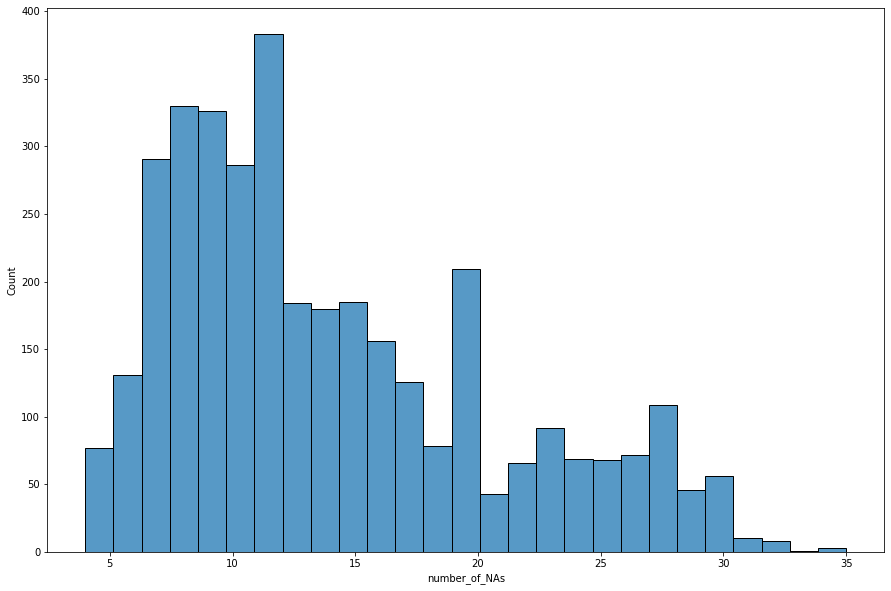

In [18]:
# Plot a histogram of number_of_NAs
plt.figure(figsize=[15, 10])
sns.histplot(x='number_of_NAs', data=boston_listings)
plt.show()

In [19]:
# Make a series that represents the proportion of NAs in a feature
listings_missingness = boston_listings.isnull().sum() / boston_listings.shape[0]

In [20]:
# Isolate empty features
empty_features = list(listings_missingness[listings_missingness >= 0.99].index)
boston_listings.drop(columns=empty_features, inplace=True)

In [21]:
# Print features are empty
empty_features

['neighbourhood_group_cleansed',
 'has_availability',
 'license',
 'jurisdiction_names']

In [22]:
# Make a series of features (index) that have missing values
listings_missingness = boston_listings.isnull().sum() / boston_listings.shape[0]
features_w_nas = list(listings_missingness[listings_missingness > 0].index)

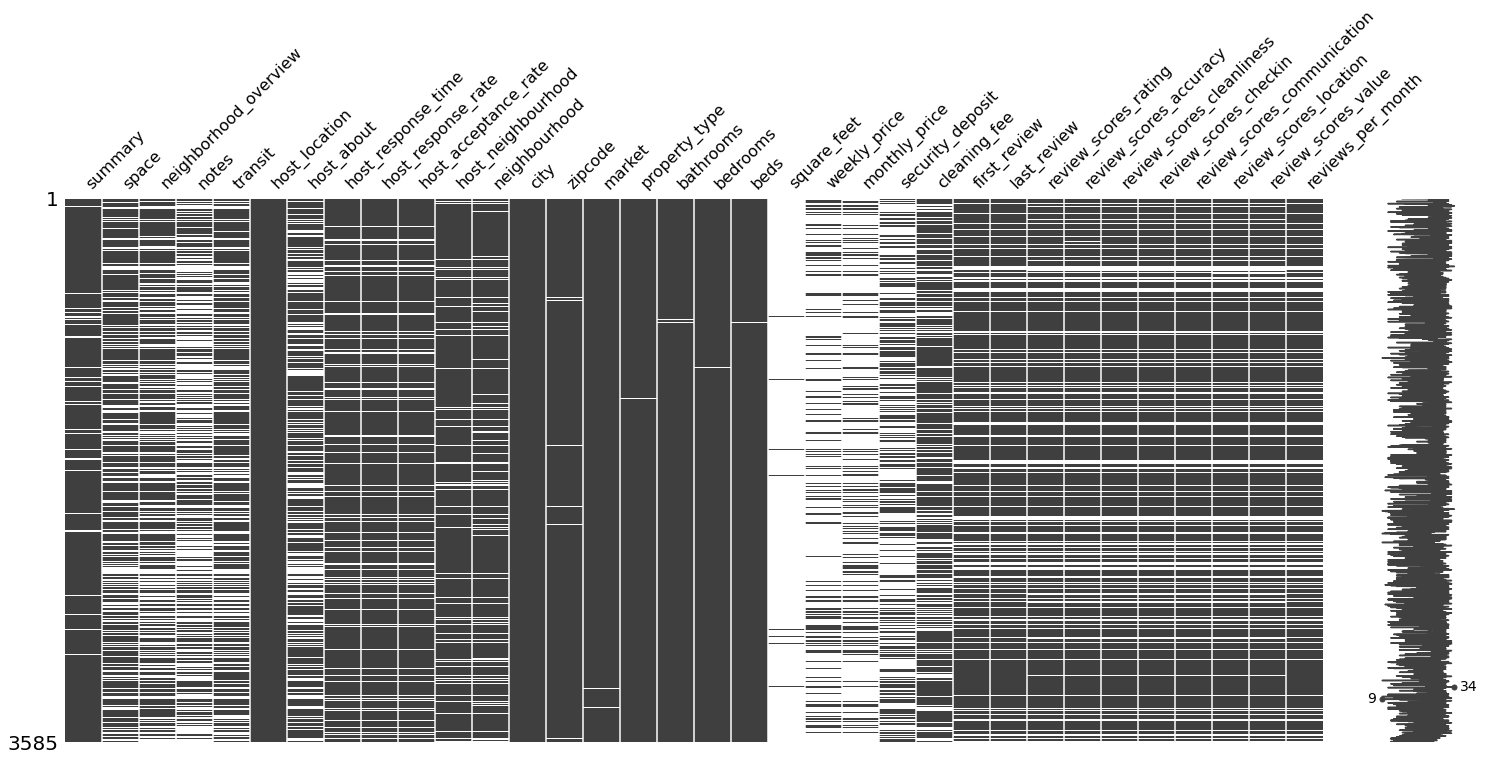

In [23]:
msno.matrix(boston_listings[features_w_nas])
plt.show()

In [24]:
# Make a dataframe of missingness to make a barplot with
missingness_summary = boston_listings.isnull().sum().reset_index(name='count')
missingness_summary.rename(columns={'index':'feature'}, inplace=True)

In [25]:
# Make a dictionary of information used for plotting the missingness barplot
info={'y':'feature', 'x':'count', 'title':'# of missing values by feature (Boston)', 'x_offset': 5, 'y_offset': -0.15,
      'hue': None}
missingness_summary = missingness_summary.loc[missingness_summary['count'] / boston_listings.shape[0] > .2, :]
missingness_summary['relative_missingness'] = missingness_summary['count'] / boston_listings.shape[0]

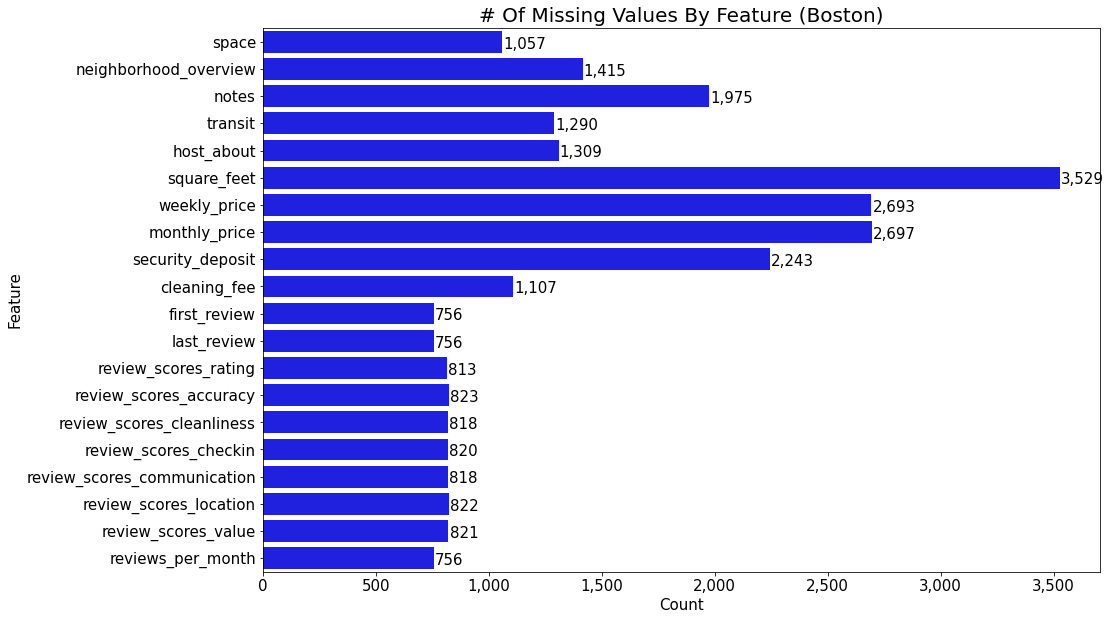

In [26]:
pts.bar_plot(missingness_summary, pts.big_mark_formatter, **info)

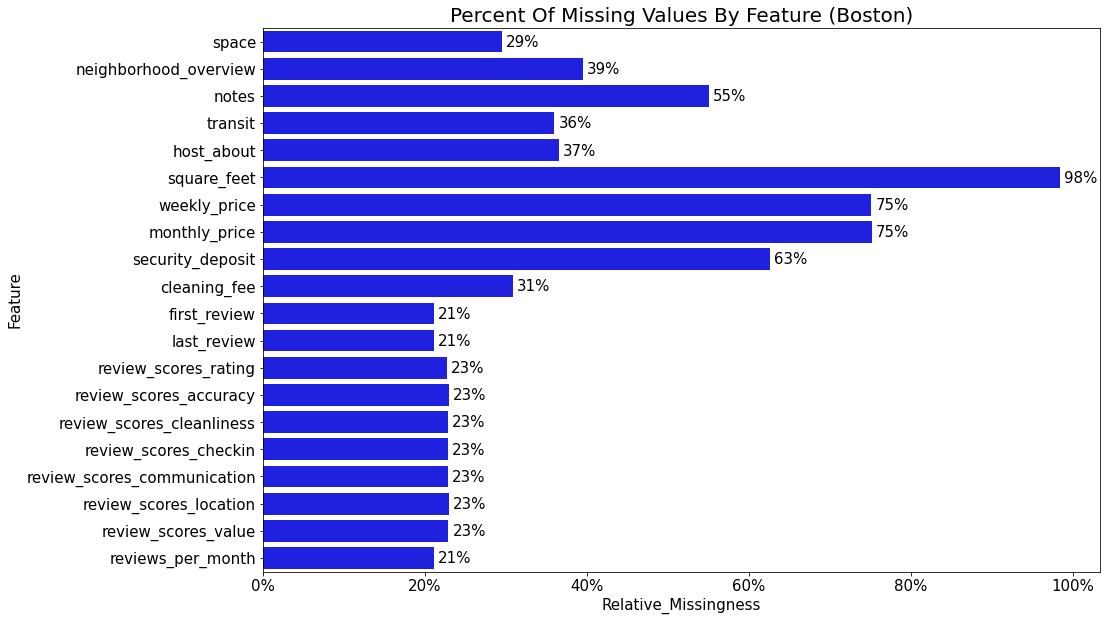

In [27]:
# Make a relative missingness barplot
info['x'] = 'relative_missingness'
info['title'] = 'Percent of missing values by feature (Boston)'
info['x_offset'] = 0.005
info['y_offset'] = -0.215
pts.bar_plot(missingness_summary, pts.percent_formatter, **info)

<a id='secondround'></a>

## Clean: More features dropped: Justification
   1. these are textual features, not categorical. These features would only be useful for large datasets where
      text mining is the focus:
      * **space**
      * **neighborhood_overview**
      * **notes**
      * **transit**
      * **access**
      * **interaction**
      * **house_rules**
      * **house_about**
      * **neighborhood_group_cleansed**
   2. Features whose contents are sparse or empty/null:
      * **neighbourhood_group_cleansed**
      * **has_availability**
      * **square_feet**
   3. **weekly_price**: these features are sparse and would require imputing too much data or removing too much data.
   4. **city** - this is a special case where the feature and it's contents are contradicting. The city should be where the property is located (Boston) which would have no variance *but* neighborhoods are given, e.g, 'Jamaica Plain' is neighborhood located in Boston, *not* a city.
   5. **market** - Another special case. There is virtually no variance in this feature. over 99% of the observations are Boston as expected. See code cell below.

In [28]:
boston_listings['market'].value_counts(normalize=True)

Boston                   0.99916
San Francisco            0.00028
Other (Domestic)         0.00028
Other (International)    0.00028
Name: market, dtype: float64

In [29]:
# Make a list of features that are either textual (and I don't plan to use), features that are sparse,
# or have no variability that I plan to drop from the dataframe
features_w_nas_to_drop = ['space', 'neighborhood_overview', 'notes', 'host_about',
                          'square_feet', 'weekly_price', 'monthly_price',
                          'first_review', 'last_review', 'market', 'city', 'transit']
boston_listings.drop(columns=features_w_nas_to_drop, inplace=True)

## Assess: NaN analysis: Conclusion:

At this point, after removing several features that either didn't seem interesting or had no variance etc. , the number of missing values is manageable. The variable with the number of missing values, **security_deposit**, I plan to use to see if there a difference between the mean number of missing values that a property has based on the review scores that the property has.

See the missingness matrix below to get a sense of the missing of each of the features that have missing values.

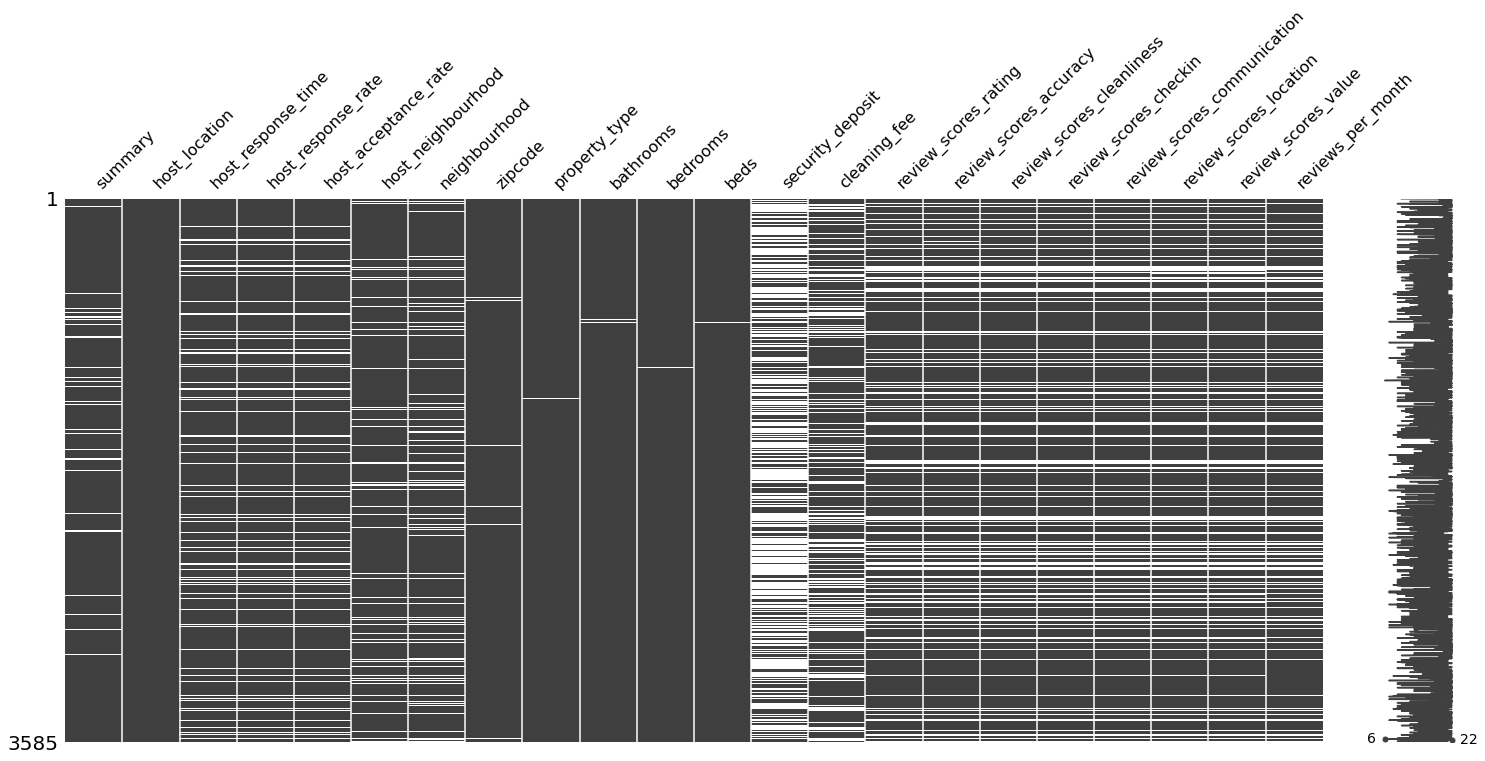

In [30]:
# Display missingness matrix of only features that have missing values
# That are left in the dataframe
listings_missingness = boston_listings.isnull().sum()
features_w_nas = list(listings_missingness[listings_missingness > 0].index)
msno.matrix(boston_listings[features_w_nas])
plt.show()

<a id='cleaning'></a>

# Prepare Data: Data Cleaning
These are ***messy*** datasets. Below I outline the issues that I needed to fix for my analysis. In addition, I demonstrate how to fix these issues on the **boston_listings** and **boston_calendar** datasets and use a cleaning function to perform the same steps on the **seattle_listings** and **seattle_calendar** dataset.

### Data Cleaning: Issues to be fixed
   1. **id** and **listing_id** need to have a primitive of 'object'.
   2. **review_scores_value** needs to be converted to an ordinal feature.
   3. **host_acceptance_rate** and **host_response_rate** - needs to have the % sign removed.
   4. needs to have 'f' and 't' replaced with respective boolean values.
      * **host_is_superhost**
      * **host_has_profile_pic**
      * **host_identity_verified**
      * **requires_license**
      * **instant_bookable**
      * **require_guest_profile_picture**
   5. Needs to have list notation replaced with '/' delimiters.
       * **host_verifications**
       * **amenities**
   6. Needs to have '\$' sign and the big-mark separator ',' removed in the listings dataset.
      * **price**
      * **security_deposity**
      * **extra_people**
      * **cleaning_fee**
   7. **zipcode** - a few zipcodes are missing and one zipcode includes route information which needs to be removed to avoid duplicate levels
   8. Some **zip_codes** include route specific codes - remove these.
   9. convert **calendar_updated** to an interval based ordinal feature.
   10. **available** needs to have the objects 't' and 'f' replaced with their boolean counterparts.
   11. **price** in the calendar dataset needs to have the '$' sign and ',' removed.
   12. **host_response_time** needs be converted to an interval based ordinal feature.
   
**NOTE**: I am converting all features to their appropriate data type since I will save the appropriate data types to a JSON for future use and easy loading.

<a id='i1'></a>

### Data Quality Issue #1:
The 'id' column needs to be converted to a string, when it is read by pd.read_csv() it parses it as an integer

In [31]:
boston_listings['id'] = boston_listings['id'].astype('object')
boston_calendar['listing_id'] = boston_calendar['listing_id'].astype('object')

<a id='i2'></a>

### Data Quality Issue #2:
**review_scores_value** should be converted to an ordinal categorical variable. In the usual case, this should only be converted when you are ready to analyze the final cleaned dataset, however, I needed to go ahead and convert it for **Question 1** above, and so I went ahead and converted it in order for a correct extraction of all categorical feature names at the very end of this notebook.

In [32]:
reviews_levels = list(boston_listings['review_scores_value'].unique())[1:]
reviews_levels = sorted(reviews_levels)
boston_listings['review_scores_value'] = pd.Categorical(boston_listings['review_scores_value'], categories=reviews_levels, ordered=True)
boston_listings['review_scores_value'].cat.add_categories([1.])
boston_listings['review_scores_value'] = pd.Categorical(boston_listings['review_scores_value'], categories=[1., 2., 3., 4., 5., 6. ,7., 8., 9., 10.],
                                                                   ordered=True)

<a id='i3'></a>

### Data Quality Issue #3:
**host_acceptance_rate** needs to have the '%' sign removed in order for it to be properly parsed into a numeric type

In [33]:
rate_features = ['host_acceptance_rate', 'host_response_rate']
for feature in rate_features:
    boston_listings[feature] = boston_listings[feature].str.replace(r'%', '', regex=True)
    boston_listings[feature] = boston_listings[feature].astype('double')

<a id='i4'></a>

### Data Quality Issue #4:
**host_is_superhost**, **host_has_profile_pic**, **host_identity_verified**, **requires_license**, **instant_bookable** and **require_guest_profile_picture** need to have the string values 't' and 'f' replaced with their boolean counterparts, namely, True and False.

In [34]:
features_to_fix = ['host_is_superhost', 'host_has_profile_pic', 'host_identity_verified', 'requires_license',
                   'instant_bookable', 'require_guest_profile_picture', 'require_guest_phone_verification']
for feature in features_to_fix:
    boston_listings[feature] = boston_listings[feature].replace({'t':True, 'f':False}).astype('bool')

<a id='i5'></a>

### Data Quality Issue #5:
This is a little subjective, but I would like **host_verifications** to be parsed into a more compact format where the forward slash ('/') is the delimiter and the quotations are removed. This will save a little bit of memory *and* the levels of this variable will be a bit more compact.

**amenities** has the same issues, but instead of contents being stored in brackets ([  ]) it's stored in braces ({  }).

In [35]:
boston_listings['host_verifications'] = boston_listings['host_verifications'].str.strip('[]').replace({r'(, )|(,)':'/', '\'':''}, regex=True)

In [36]:
boston_listings['amenities'] = boston_listings['amenities'].str.strip('{}').replace({r'(, )|(,)':'/', '\"':''}, regex=True)

<a id='i6'></a>

### Data Quality Issue #6:
**price**, **security_deposity**, **extra_people** and **cleaning_fee** needs to have the '$' sign removed so they can be properly parsed into numeric data types

In [37]:
features_w_dollar_signs = ['price', 'security_deposit', 'cleaning_fee', 'extra_people']
for feature in features_w_dollar_signs:
    boston_listings[feature] = boston_listings[feature].str.replace(r'(\$)|(\,)', '', regex=True)
    boston_listings[feature] = boston_listings[feature].astype('double')

<a id='i7'></a>

### Data Quality Issue #7: **zipcodes** has missing values

The code cell below shows that the 38 zipcodes that are missing from the **zipcodes** feature are exactly that are missing from the **street**. Therefore, unfortunately we cannot replace the missing values of zipcodes.

In [38]:
zipcodes_from_street = boston_listings['street'].str.extract(r'(\d+)').squeeze()
zc_from_street_that_are_null = list(zipcodes_from_street[boston_listings['zipcode'].isnull()].index)
zipcodes_are_null = list(boston_listings.loc[boston_listings['zipcode'].isnull()].index)
bool_list = []
for row in zc_from_street_that_are_null:
    if row in zipcodes_are_null:
        bool_list.append(True)
    else:
        bool_list.append(False)
assert sum(bool_list) == 38

<a id='i8'></a>

### Data Quality Issue #8: some zipcodes include routing numbers

After verifying that we cannot replace the missing values of zipcode, I remove the routing codes from the zipcodes that include them.

In [39]:
boston_listings['zipcode'] = boston_listings['zipcode'].str.replace(r'(-\d+)|(\s\d+)', '', regex=True)

<a id='i9'></a>

### Data Quality Issue #9:
Convert **calendar_updated** to an interval based ordinal categorical variable.

In [40]:
mapper = {'today': '0', 'yesterday': '1', '2 days ago': '2', '3 days ago': '3', '4 days ago': '4',
          '5 days ago': '5', '6 days ago': '6', 'a week ago': '7', '1 week ago': '7', '2 weeks ago': '14'}
boston_listings['calendar_updated'] = boston_listings['calendar_updated'].replace(mapper).str.replace(r'\d+\s+\w+\s*\w+|never', '15',
                                                                                                      regex=True)

In [41]:
boston_listings['calendar_updated'] = pd.cut(boston_listings['calendar_updated'].astype('int'),
                                             bins=[0, 1, 2, 3, 4, 5, 6, 7, 14, 15], labels=['0-1', '1-2', '2-3',
                                                                                            '3-4', '4-5', '5-6',
                                                                                            '6-7', '7-14', '14+'])

In [42]:
boston_listings['calendar_updated'].value_counts(normalize=True)

14+     0.494186
6-7     0.136628
7-14    0.111555
0-1     0.063227
3-4     0.061047
4-5     0.047965
2-3     0.036701
1-2     0.035610
5-6     0.013081
Name: calendar_updated, dtype: float64

<a id='i10'></a>

### Data Quality Issue #10:
The **available** feature in both the ***calendar*** datasets have the familiar labels 't' and 'f' - replace these values with their boolean counterparts.

This is the only change that I see necessary to this dataset, so it is easy enough to just implement the fix here and not generate a function

In [43]:
boston_calendar['available'] = boston_calendar['available'].replace({'t':True, 'f':False})

In [44]:
boston_calendar['available'].value_counts(normalize=True)

False    0.508716
True     0.491284
Name: available, dtype: float64

<a id='i11'></a>

### Data Quality Issue #11:
The **price** feature needs to have the $ sign removed in order to Pandas to be able to parse it to a numerical dtype.

In [45]:
boston_calendar['price'] = boston_calendar['price'].str.replace(r'(\$)|(,)', '', regex=True).str.strip().astype('double')

<a id='i12'></a>

### Data Quality Issue #12:
Convert **host_response_time** to an interval based ordinal categorical variable.

In [46]:
boston_listings['host_response_time'] = boston_listings['host_response_time']\
                                                       .replace({'within an hour':1, 'within a few hours':3,
                                                       'within a day': 24, 'a few days or more':72})

In [47]:
boston_listings['host_response_time'] = pd.cut(boston_listings['host_response_time'], bins=[0, 1, 3, 24, 72], labels=['0-1', '1-3', '3-24', '24+'])

<a id='cleanseattle'></a>

## Clean the Seattle Datasets
I use the **cleaning_utils** module that I made to do this; the cleaning functions in this module are specific to the airbnb datasets and perform the data quality corrections performed on the Boston datasets.

In [48]:
seattle_listings['number_of_NAs'] = seattle_listings.isnull().sum(axis=1)

In [49]:
features_map = {'features_to_drop':features_to_drop, 'features_w_nas_to_drop':features_w_nas_to_drop,
                'features_to_fix':features_to_fix, 'rate_features':rate_features,
                'features_w_dollar_signs':features_w_dollar_signs, 'missing_features':missing_features,
                'empty_features':empty_features, 'mapper':mapper, 'reviews_levels':reviews_levels}
c.clean_airbnb_listings(seattle_listings, **features_map)

In [50]:
assert seattle_listings.shape[1] == boston_listings.shape[1]

In [51]:
for feature in boston_listings.columns:
    if feature not in seattle_listings.columns:
        print(feature)

In [52]:
seattle_listings['calendar_updated'].value_counts(normalize=True)

14+     0.545308
7-14    0.111504
6-7     0.088046
0-1     0.074229
2-3     0.052057
3-4     0.046594
4-5     0.042416
1-2     0.030848
5-6     0.008997
Name: calendar_updated, dtype: float64

In [53]:
c.clean_airbnb_calendar(seattle_calendar)

<a id='comp'></a>

### Compare the structure of the Seattle and Boston datasets
We can do this by using the Pandas.DataFrame.shape field

   * Both datasets have a similar number of observations
   * Both datasets have the *exact* same number of features with one exception
   * The Seattle listings dataset has *three* less features than the boston listings dataset - the excess features in the boston dataset should be dropped to avoid NaNs

In [54]:
# Print the structures of the dataframes for each city
cal_string = (f'Boston calendar shape: '
              f'({boston_calendar.shape[0]:,}: {boston_calendar.shape[1]})\n'
              f'Seattle calendar shape: '
              f'({seattle_calendar.shape[0]:,}: {seattle_calendar.shape[1]})\n\n')
listings_string = (f'Boston listings shape: '
                   f'({boston_listings.shape[0]:,}: {boston_listings.shape[1]})\n'
                   f'Seattle listings shape: '
                   f'({seattle_listings.shape[0]:,}: {seattle_listings.shape[1]})\n\n')
reviews_string = (f'Bostons reviews shape: '
                  f'({boston_reviews.shape[0]:,}: {boston_reviews.shape[1]})\n'
                  f'Seattle reviews shape: '
                  f'({seattle_reviews.shape[0]:,}: {seattle_reviews.shape[1]})\n')
print(cal_string)
print(listings_string)
print(reviews_string)

Boston calendar shape: (1,308,890: 4)
Seattle calendar shape: (1,393,570: 4)


Boston listings shape: (3,585: 62)
Seattle listings shape: (3,818: 62)


Bostons reviews shape: (68,275: 6)
Seattle reviews shape: (84,849: 6)



In [55]:
# Save all of these clean individual dataframes
boston_listings.to_csv('boston_listings.csv', index=False)
seattle_listings.to_csv('seattle_listings.csv', index=False)
boston_calendar.to_csv('boston_calendar.csv', index=False)
seattle_calendar.to_csv('seattle_calendar.csv', index=False)

<a id='jsontypes'></a>

### Make a JSON containing category types for the listings
In the below code cells I save dictionaries that map the feature name (key) to the corresponding primitive (value) of each of the features in the saved datasets; doing this will make it much easier to correctly parse the datasets when I go to analyze them.

In [56]:
# Make a list of categorical features in the boston_listings dataset
categorical_features_boston = list(boston_listings.select_dtypes(exclude=['datetime', 'number']).columns)

In [57]:
# make a list of the categorical features in the seattle_listings dataset
categorial_features_seattle = list(seattle_listings.select_dtypes(exclude=['datetime', 'number']).columns)

In [58]:
# print any features that are categorical in the boston_listings dataset but that are not categorical
# in the seattle_listings dataset
for feature in categorical_features_boston:
    if feature not in categorial_features_seattle:
        print(feature)

In [59]:
# make a list of textual features in the _listings datsets
textual_features = ['id', 'name', 'summary', 'description', 'amenities']

In [60]:
# make a list of categorical features, but exclude the textual features, in the _listings datasets
cat_features = [feature for feature in categorical_features_boston if feature not in textual_features]

In [61]:
# create a dictionary of categorical features
cat_features_map = {}
for feature in cat_features:
    cat_features_map[feature] = 'category'

In [62]:
# make a dictionary mapping the feature name to the primitive in the _listing datasets
type_dict = {}
for feature in boston_listings.columns:
    if (feature in cat_features) or ('review' in feature):
        type_dict[feature] = 'category'
    elif feature in textual_features:
        type_dict[feature] = 'object'
    else:
        continue

In [63]:
# write the listings names and primitives to a json
with open('listings_feature_types.json', 'w') as f:
    json.dump(type_dict, f)

<a id='mergecalendar'></a>

### Make aggregated datasets from the calendar datasets and then merge the appropriate \_listings dataset and aggregated dataset
I want to calculate the mean, standard deviation and median of the daily price for each property listing on airbnb in both of these cities (Boston and Seattle), therefore, I will create a dataframe of listing_id, and then the mean/median/standard deviation of each property in both of these cities, individually.

In [64]:
# Make a list of statistical measures that I wish to have the value of
# for each airbnb property listing
list_of_funcs = [np.mean, np.std, np.median]
names_of_funcs = ['mean_price', 'stand_dev_price', 'median_price']

<a id='mergebostoncalendarlistings'></a>

### Merge Boston Listings and Calendar Datasets
Merge the aggregate Boston dataframe and the boston_listings dataframe.

In [65]:
# Make a dataframe that groups and then aggregates by property id
boston_aggregated_dataframe = c.make_aggregated_dataframe(boston_calendar, list_of_funcs, names_of_funcs)
boston_aggregated_dataframe.head()

,listing_id,mean_price,stand_dev_price,median_price
0,3075044,67.81337,4.502791,65.0
1,6976,65.00000,0.000000,65.0
2,1436513,75.00000,0.000000,75.0
3,7651065,79.00000,0.000000,79.0
4,12386020,75.00000,0.000000,75.0


In [66]:
# Merge the calendar and listings Boston dataframes and then recreate a more
# consistent 'city' feature
boston_merged = boston_listings.merge(boston_aggregated_dataframe, left_on='id', right_on='listing_id', how='left')
boston_merged['city'] = 'Boston'

In [67]:
boston_merged.sample(5)

,id,name,summary,description,experiences_offered,host_since,host_location,host_response_time,host_response_rate,host_acceptance_rate,...,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month,number_of_NAs,listing_id,mean_price,stand_dev_price,median_price,city
3190,7841193,Sunny South Boston apartment,"- Very recently renovated, new hardwood, tile ...","- Very recently renovated, new hardwood, tile ...",none,2015-08-12,"Boston, Massachusetts, United States",NaN,NaN,NaN,...,False,False,1,0.08,17,NaN,NaN,NaN,NaN,Boston
1061,990668,"zzEastPrivateBedBath MinsToBus,Metro,HistoricS...","French doors open onto the Atrium. Share LR,...","French doors open onto the Atrium. Share LR,...",none,2012-01-25,"Boston, Massachusetts, United States",0-1,100.0,94.0,...,True,True,6,2.41,7,990668,162.939597,12.924013,162.0,Boston
217,7790454,Vacation Rental,My home is a beautiful old victorian condomini...,My home is a beautiful old victorian condomini...,none,2011-07-25,"Boston, Massachusetts, United States",0-1,100.0,100.0,...,False,False,2,NaN,25,7790454,186.714286,5.012464,184.0,Boston
965,13707814,Quiet 2 bedroom South End Condo,800 sq ft 2 bedroom/1 bath condo in the South ...,800 sq ft 2 bedroom/1 bath condo in the South ...,none,2016-01-30,US,0-1,100.0,70.0,...,False,False,1,1.13,15,13707814,250.000000,0.000000,250.0,Boston
3542,14902894,Suite _Charles River/MIT/BU/Fanway Park,MPrime CambridgePort location on Quiet Area Wa...,MPrime CambridgePort location on Quiet Area Wa...,none,2014-06-30,"Cambridge, Massachusetts, United States",0-1,100.0,81.0,...,False,False,1,NaN,19,14902894,132.769886,12.531938,140.0,Boston


<a id='mergeseattlecalendarlistings'></a>

### Merge Seattle Listings and Calendar Datasets
Merge the Seattle aggregate dataframe and seattle_listings dataframe

In [68]:
# Make a dataframe that groups and then aggregates by property id in Seattle
seattle_aggregated_dataframe = c.make_aggregated_dataframe(seattle_calendar, list_of_funcs, names_of_funcs)
seattle_aggregated_dataframe.head()

,listing_id,mean_price,stand_dev_price,median_price
0,241032,85.000000,0.000000,85.0
1,953595,170.931271,37.225252,171.0
2,3308979,1301.818182,356.322687,1450.0
3,7421966,100.000000,0.000000,100.0
4,278830,462.739726,23.703194,450.0


In [69]:
# Merge the calendar and listings dataframes for Seattle
seattle_merged = seattle_listings.merge(seattle_aggregated_dataframe, left_on='id', right_on='listing_id', how='left')

In [70]:
# Recreate a more consistent 'city' feature
seattle_merged['city'] = 'Seattle'

In [71]:
seattle_merged.sample(5)

,id,name,summary,description,experiences_offered,host_since,host_location,host_response_time,host_response_rate,host_acceptance_rate,...,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month,number_of_NAs,listing_id,mean_price,stand_dev_price,median_price,city
3556,194313,Slanted Ivy Vacation Rental,Charming studio in the basement of my 1910 Cra...,Charming studio in the basement of my 1910 Cra...,none,2011-08-09,"Seattle, Washington, United States",0-1,100.0,100.0,...,False,False,1,1.30,3,194313,99.00,0.00000,99.0,Seattle
1863,692080,Hummingbird House+Firelight Studio,See listings for Firelight Studio and for Humm...,See listings for Firelight Studio and for Humm...,none,2010-08-18,"Seattle, Washington, United States",NaN,NaN,NaN,...,False,False,1,0.09,13,692080,370.00,0.00000,370.0,Seattle
3678,9511777,New LUXURY house - heart of Fremont,4-story upscale townhouse beautifully decorate...,4-story upscale townhouse beautifully decorate...,none,2015-11-05,"Seattle, Washington, United States",0-1,100.0,100.0,...,False,False,1,0.81,9,9511777,183.75,16.85018,180.0,Seattle
654,6292452,Modern Home in the heart of Seattle,We have a fabulous new home in the heart of on...,We have a fabulous new home in the heart of on...,none,2012-08-31,US,NaN,NaN,NaN,...,False,False,1,0.15,10,6292452,250.00,0.00000,250.0,Seattle
2191,8541389,Funky home in Rainier Beach,This is a fun funky home has a large outdoor s...,This is a fun funky home has a large outdoor s...,none,2015-08-31,"Seattle, Washington, United States",NaN,NaN,NaN,...,False,False,1,NaN,23,8541389,90.00,0.00000,90.0,Seattle


<a id='jsonconcaggs'></a>

### Make a JSON of the primitives for the aggregated datasets.
For **only** the aggregate datasets.

In [72]:
# make a dictionary of the primitives for the aggregated datasets and then write to disk
aggregated_type_dict = {'listing_id':'object', 'mean_price':'float', 'stand_dev_price':'float',
                        'median_price':'float'}
with open('aggregated_features_types.json', 'w') as f:
    json.dump(aggregated_type_dict, f)

<a id='aggmergecal'></a>

### Concatenate the merged datasets together
Merge the aggregate/listing dataframes for both Boston and Seattle.

In [73]:
# Row-wise merge the boston and seattle calendar, listings dataframes
calendar_listings = pd.concat([boston_merged, seattle_merged])

In [74]:
calendar_listings.sample(5)

,id,name,summary,description,experiences_offered,host_since,host_location,host_response_time,host_response_rate,host_acceptance_rate,...,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month,number_of_NAs,listing_id,mean_price,stand_dev_price,median_price,city
427,11861063,Studio apt. w/ kitchenette and bath,Private entrance; private bath; 5 minute walk ...,Private entrance; private bath; 5 minute walk ...,none,2016-03-16,"Boston, Massachusetts, United States",1-3,100.0,91.0,...,False,False,1,2.10,11,11861063,72.441667,2.028353,72.0,Boston
1376,13674964,Boston Back Bay Penthouse,Private bedroom and bathroom in beautiful Newb...,Private bedroom and bathroom in beautiful Newb...,none,2014-02-09,"Boston, Massachusetts, United States",1-3,92.0,100.0,...,False,False,1,5.00,9,13674964,150.033333,10.639602,148.5,Boston
174,3730447,Parkside Apartment- Cozy and Roomy!,This 2 bedroom condo is the entire second floo...,This 2 bedroom condo is the entire second floo...,none,2013-10-09,"Boston, Massachusetts, United States",1-3,100.0,20.0,...,False,False,2,1.14,8,3730447,180.000000,0.000000,180.0,Boston
41,2715623,"DARLING VINTAGE COTTAGE, QUEEN ANNE","Why stay in a hotel costing more, when you can...","Why stay in a hotel costing more, when you can...",none,2013-08-18,"Seattle, Washington, United States",1-3,100.0,100.0,...,True,True,1,0.46,8,2715623,184.467742,91.531967,164.0,Seattle
2054,13926017,Penthouse near the Commons,Cozy two bedroom flat in Boston. This beautifu...,Cozy two bedroom flat in Boston. This beautifu...,none,2015-06-28,"New York, New York, United States",0-1,86.0,99.0,...,False,False,2,2.14,13,13926017,290.000000,0.000000,290.0,Boston


In [75]:
# See how balanced the newly merged Seattle and Boston dataset is: they are fairly balanced
calendar_listings['city'].value_counts(normalize=True)

Seattle    0.515737
Boston     0.484263
Name: city, dtype: float64

In [76]:
# save the concatenated _listings and calendar datasets
calendar_listings.to_csv('calendar_listings.csv', index=False)

<a id='typejsonmergedcalendarlistings'></a>

### Make JSON of the primitives of concatenated \_calendar and \_listings datasets

In [77]:
# Combine the aggregated dataset data types with the calendar_listings data types
type_dict.update(aggregated_type_dict)
type_dict.update({'city':'category'})

In [78]:
type_dict

{'id': 'object',
 'name': 'object',
 'summary': 'object',
 'description': 'object',
 'experiences_offered': 'category',
 'host_location': 'category',
 'host_response_time': 'category',
 'host_is_superhost': 'category',
 'host_neighbourhood': 'category',
 'host_verifications': 'category',
 'host_has_profile_pic': 'category',
 'host_identity_verified': 'category',
 'street': 'category',
 'neighbourhood': 'category',
 'neighbourhood_cleansed': 'category',
 'state': 'category',
 'zipcode': 'category',
 'smart_location': 'category',
 'is_location_exact': 'category',
 'property_type': 'category',
 'room_type': 'category',
 'bed_type': 'category',
 'amenities': 'object',
 'calendar_updated': 'category',
 'number_of_reviews': 'category',
 'review_scores_rating': 'category',
 'review_scores_accuracy': 'category',
 'review_scores_cleanliness': 'category',
 'review_scores_checkin': 'category',
 'review_scores_communication': 'category',
 'review_scores_location': 'category',
 'review_scores_value

In [79]:
# Save the type dicitonary as a JSON for casting each feature to its most
# appropriate data type
with open('feat_types_merged_calendar_listings.json', 'w') as f:
    json.dump(type_dict, f)

<a id='addcityreviews'></a>

### Add City as a Feature to the Reviews Dataset

In [80]:
# Add a feature to the 'reviews' datasets that identifies the city
boston_reviews['city'] = 'Boston'
seattle_reviews['city'] = 'Seattle'

In [81]:
# Make a dictionary of the primitive data types for each features and save it as a JSON
reviews_type_dict = {'listing_id':'object', 'id':'object', 'reviewer_id':'object', 'reviewer_name':'object',
                     'comments':'object', 'city':'category'}
with open('reviews_type_dict.json', 'w') as f:
    json.dump(reviews_type_dict, f)

In [82]:
# Row-wise merge the Boston and Seattle reviews dataframes
reviews_concatenated = pd.concat([boston_reviews, seattle_reviews])

In [83]:
reviews_concatenated.sample(5)

,listing_id,id,date,reviewer_id,reviewer_name,comments,city
19897,9473816,90037095,2016-07-31,2066238,Jasmine,We loved the place. It was perfect for our fam...,Boston
45262,4695542,66391814,2016-03-22,42396258,Daniel,Sitio limpio con acceso directo al centro de b...,Boston
71976,5470943,54013594,2015-11-15,2475596,Nicole,This is by far my favorite place. Matthew keep...,Seattle
64599,10850420,64161268,2016-02-29,12591930,Timothy,"The host was accommodating, the studio was awe...",Boston
73873,789966,17370168,2014-08-11,11028246,Joanna,The neighborhood is semi-quiet and seemed very...,Seattle


In [84]:
# Save the newly merged Boston and Seattle reviews dataframes
reviews_concatenated.to_csv('reviews_concatenated.csv', index=False)